In [141]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
from autora.experiment_runner.synthetic.neuroscience import task_switching
from autora.experimentalist.random import random_pool
from autora.experimentalist.grid import grid_pool
from random_pool_with_fixed_variable import random_pool_with_fixed_variable
from regressor_experimentalist import regressor_experimentalist
from autora.state import StandardState, on_state
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from utils import get_switch_costs_from_results

## Plotting the switch cost heat map

In [195]:
experiment = task_switching.task_switching()
pool = grid_pool(experiment.variables)
experimental_space = experiment.run(pool, added_noise=0.0)

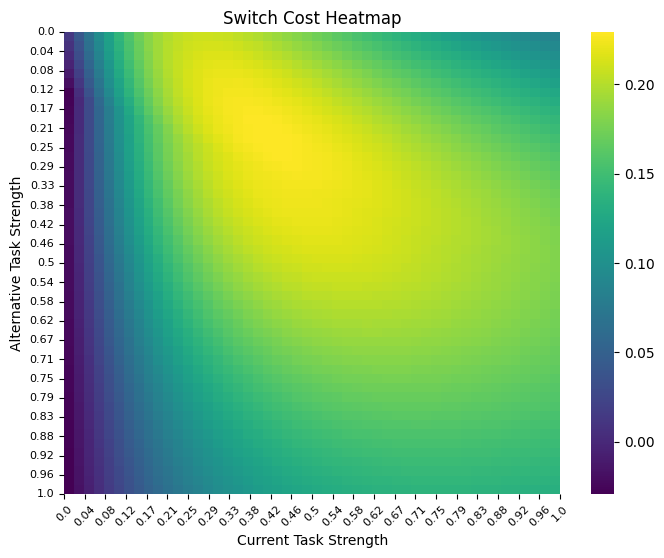

In [196]:
def plot_heatmap(df):
    # Plot heatmap
    plt.figure(figsize=(8, 6))
    
    # Use the actual values for tick positions
    ax = sns.heatmap(df, cmap='viridis')
    
    # Set the tick labels to map to actual data ranges
    grid_size = 50
    num_ticks = 25
    ax.set_xticks(np.linspace(0, grid_size, num_ticks))  # Position on the grid
    ax.set_xticklabels(np.round(np.linspace(0, 1, num_ticks), 2), rotation=45)  # Actual values
    ax.set_yticks(np.linspace(0, grid_size, num_ticks))  # Position on the grid
    ax.set_yticklabels(np.round(np.linspace(0, 1, num_ticks), 2), rotation=0)  # Actual values
    ax.tick_params(axis='both', which='major', labelsize=8)

    # Add labels and title
    plt.title("Switch Cost Heatmap")
    plt.xlabel("Current Task Strength")
    plt.ylabel("Alternative Task Strength")

    plt.show()
switch_costs_df = experimental_space.groupby(['cur_task_strength', 'alt_task_strength']).apply(
    lambda x: x.loc[x['is_switch'] == 0, 'cur_task_performance'].values[0] - 
              x.loc[x['is_switch'] == 1, 'cur_task_performance'].values[0],
              include_groups=False
)

# Calculate switch cost for each combination of cur_task_strength and alt_task_strength
switch_costs_df = experimental_space.groupby(['cur_task_strength', 'alt_task_strength']).apply(
    lambda x: x.loc[x['is_switch'] == 0, 'cur_task_performance'].values[0] - 
              x.loc[x['is_switch'] == 1, 'cur_task_performance'].values[0],
              include_groups=False
).reset_index(name='switch_cost')
pivot_df = switch_costs_df.pivot(index='alt_task_strength', columns='cur_task_strength', values='switch_cost')
plot_heatmap(pivot_df)

In [197]:
# find row with maximum switch cost in switch_costs_df
max_switch_cost_row = switch_costs_df.loc[switch_costs_df['switch_cost'].idxmax()]
print(f"Highest switch cost: {max_switch_cost_row['switch_cost']} at cur_task_strength={max_switch_cost_row['cur_task_strength']} and alt_task_strength={max_switch_cost_row['alt_task_strength']}")

Highest switch cost: 0.22929210803817202 at cur_task_strength=0.42000000000000004 and alt_task_strength=0.24


## Setting up the closed loop

In [172]:
def only_experimentalist_closed_loop(experimentalist, experiment, num_loops=10, experimentalist_args=dict()):
    """
    A closed loop including only the experimentalist and the experiment.
    """
    # initial seed conditions
    initial_conditions = random_pool_with_fixed_variable(experiment.variables, random_state=42, num_sample_groups=1)
    # Initialize the state
    s = StandardState(
        variables = experiment.variables,
        conditions = initial_conditions,
        experiment_data = pd.DataFrame(columns=[var.name for var in experiment.variables.independent_variables + experiment.variables.dependent_variables]),
    )
    experimentalist_on_state = on_state(experimentalist, output=["conditions"])
    experiment_runner_on_state = on_state(experiment.run, output=["experiment_data"])
    
    # Run the experiment
    for loop in range(num_loops):
        s = experimentalist_on_state(s, **experimentalist_args)
        s = experiment_runner_on_state(s, random_state=42+loop)
        
    return s

### Using a random experimentalist

In [198]:
experimentalist = random_pool_with_fixed_variable
experiment = task_switching.task_switching()
num_loops = 100
num_sample_groups_per_loop = 1
s = only_experimentalist_closed_loop(experimentalist, experiment, num_loops=num_loops,
                                     experimentalist_args=dict(num_sample_groups=num_sample_groups_per_loop, fixed_var_name="is_switch"))
random_experimentalist_switch_costs = get_switch_costs_from_results(s.experiment_data)
random_results = pd.DataFrame({
    'iteration': range(num_loops),  # Iteration number
    'switch_cost': random_experimentalist_switch_costs,  # Switch cost achieved
    'cur_task_strength': s.experiment_data.cur_task_strength[::2],  # Current task strength
    'alt_task_strength': s.experiment_data.alt_task_strength[::2],  # Alternative task strength
})


/Users/syntactic/miniconda3/envs/autora/lib/python3.10/site-packages/autora/state.py:417: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat((a, b), ignore_index=True)


### Using a regressor experimentalist

In [199]:
experimentalist = regressor_experimentalist
experiment = task_switching.task_switching()
num_loops = 100
num_sample_groups_per_loop = 1
s = only_experimentalist_closed_loop(experimentalist, experiment, num_loops=num_loops,
                                     experimentalist_args=dict(fixed_var_name="is_switch"))
regressor_experimentalist_switch_costs = get_switch_costs_from_results(s.experiment_data)
regressor_results = pd.DataFrame({
    'iteration': range(num_loops),  # Iteration number
    'switch_cost': regressor_experimentalist_switch_costs,  # Switch cost achieved
    'cur_task_strength': s.experiment_data.cur_task_strength[::2],  # Current task strength
    'alt_task_strength': s.experiment_data.alt_task_strength[::2],  # Alternative task strength
})

/Users/syntactic/miniconda3/envs/autora/lib/python3.10/site-packages/autora/state.py:417: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat((a, b), ignore_index=True)


## Evaluation
### Visualizing the experimentalists' proposals

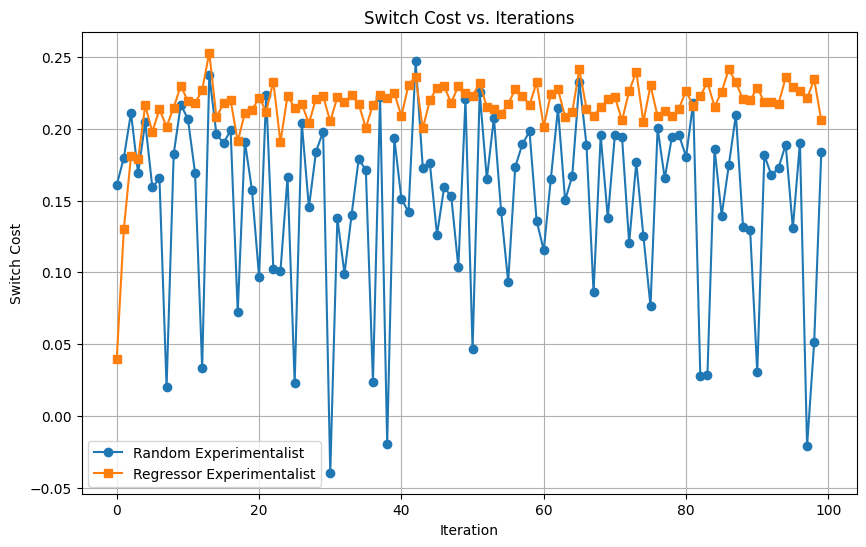

In [188]:
plt.figure(figsize=(10, 6))
plt.plot(random_results['iteration'], random_results['switch_cost'], label='Random Experimentalist', marker='o')
plt.plot(regressor_results['iteration'], regressor_results['switch_cost'], label='Regressor Experimentalist', marker='s')
plt.title('Switch Cost vs. Iterations')
plt.xlabel('Iteration')
plt.ylabel('Switch Cost')
plt.legend()
plt.grid(True)
plt.show()

### Quantifying the effectiveness of the experimentalists

We can take the final twenty iterations of the loop and see what the average switch costs are of the conditions proposed by each experimentalist, to get an idea of how good their last proposals are.

In [193]:
# First n iterations (e.g., 20)
n = 20
random_avg_switch_cost = random_results['switch_cost'][-n:].mean()
regressor_avg_switch_cost = regressor_results['switch_cost'][-n:].mean()

print(f'Average Switch Cost over last {n} iterations:')
print(f'Random Experimentalist: {random_avg_switch_cost:.4f}')
print(f'Regressor Experimentalist: {regressor_avg_switch_cost:.4f}')

Average Switch Cost over last 20 iterations:
Random Experimentalist: 0.1351
Regressor Experimentalist: 0.2244


To compare the experimentalists over the course of the entire closed loop, we can look at area under the curve.

In [200]:
from numpy import trapz

# Compute AUC for switch cost vs. iterations
random_auc = trapz(random_results['switch_cost'], dx=1)
regressor_auc = trapz(regressor_results['switch_cost'], dx=1)

print(f'Area Under Curve (AUC):')
print(f'Random Experimentalist: {random_auc:.4f}')
print(f'Regressor Experimentalist: {regressor_auc:.4f}')

Area Under Curve (AUC):
Random Experimentalist: 14.4801
Regressor Experimentalist: 21.4340
